In [1]:
%matplotlib notebook
import pandas
import glob
import json
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Load and Transform Data

In [2]:
glob.glob("data/*.json")

['data/data_2019-05-11-165114.json']

In [3]:
raw = []
datafile = 'data/data_2019-05-11-165114.json'
with open(datafile, "r") as f:
    for row in f:
        item = json.loads(row)
        raw.append(item)

print("{} samples".format(len(raw)))

192 samples


In [4]:
pprint(raw[0])

{'distance': {'cm': 176.06, 'inches': 69.32},
 'euler_angles': {'heading': 179.6875, 'pitch': -0.9375, 'roll': 5.6875},
 'imu_calibration': {'accelerometer': 3,
                     'gyroscope': 3,
                     'magnetometer': 2,
                     'system': 3},
 'linear_acceleration': {'x': -0.01, 'y': -0.14, 'z': -0.49},
 'quaternion': {'w': -0.002685546875,
                'x': 0.050048828125,
                'y': 0.00830078125,
                'z': 0.99871826171875},
 'time': {'scale': 'microsecond', 'start': 1557607874229124}}


In [5]:
def transform(instance):
    obj = {
        "time": instance["time"]["start"],
    }
    obj.update(instance["euler_angles"])
    return obj

data = [transform(ii) for ii in raw]

How much data do we have?

In [6]:
duration = data[-1]["time"] - data[0]["time"]
print("data is {:,} microseconds ({:,} seconds) long".format(duration, duration * 1e-6))
print("there are {} samples".format(len(data)))
print("{:.6f} seconds per sample".format( len(data) / duration ))
print("{:.2f} samples per second".format( duration / len(data) ))

data is 17,703,174 microseconds (17.703174 seconds) long
there are 192 samples
0.000011 seconds per sample
92204.03 samples per second


# Determine direction and change of direction

In [7]:
df = pandas.DataFrame(data)
df["time"] = pandas.to_datetime(df["time"], unit='us')

# df["elapsed"] = df['time'].rolling(window=2).apply(lambda x: (x[1] - x[0]))

df["direction"] = df['heading'].rolling(window=2).apply(lambda x: x[1] - x[0] > 0, raw=True)
df["change"] = df['direction'].rolling(window=2).apply(lambda x: x[0] != x[1], raw=True).shift(-1)
df.set_index("time", inplace=True)
df.head(10)

,heading,pitch,roll,direction,change
time,,,,,
2019-05-11 20:51:14.229124,179.6875,-0.9375,5.6875,NaN,NaN
2019-05-11 20:51:14.304674,179.6875,-1.0000,5.6250,0.0,0.0
2019-05-11 20:51:14.377057,179.6875,-1.0625,5.5000,0.0,0.0
2019-05-11 20:51:14.456709,179.6250,-1.1875,5.3125,0.0,0.0
2019-05-11 20:51:14.530917,179.5000,-1.1875,5.0625,0.0,0.0
2019-05-11 20:51:14.606482,179.5000,-1.1875,4.7500,0.0,0.0
2019-05-11 20:51:14.680647,179.5000,-1.1875,4.6250,0.0,1.0
2019-05-11 20:51:14.757090,179.6250,-1.1875,4.3750,1.0,0.0
2019-05-11 20:51:14.831089,179.6875,-1.0000,4.0625,1.0,0.0


# Plot heading

<IPython.core.display.Javascript object>


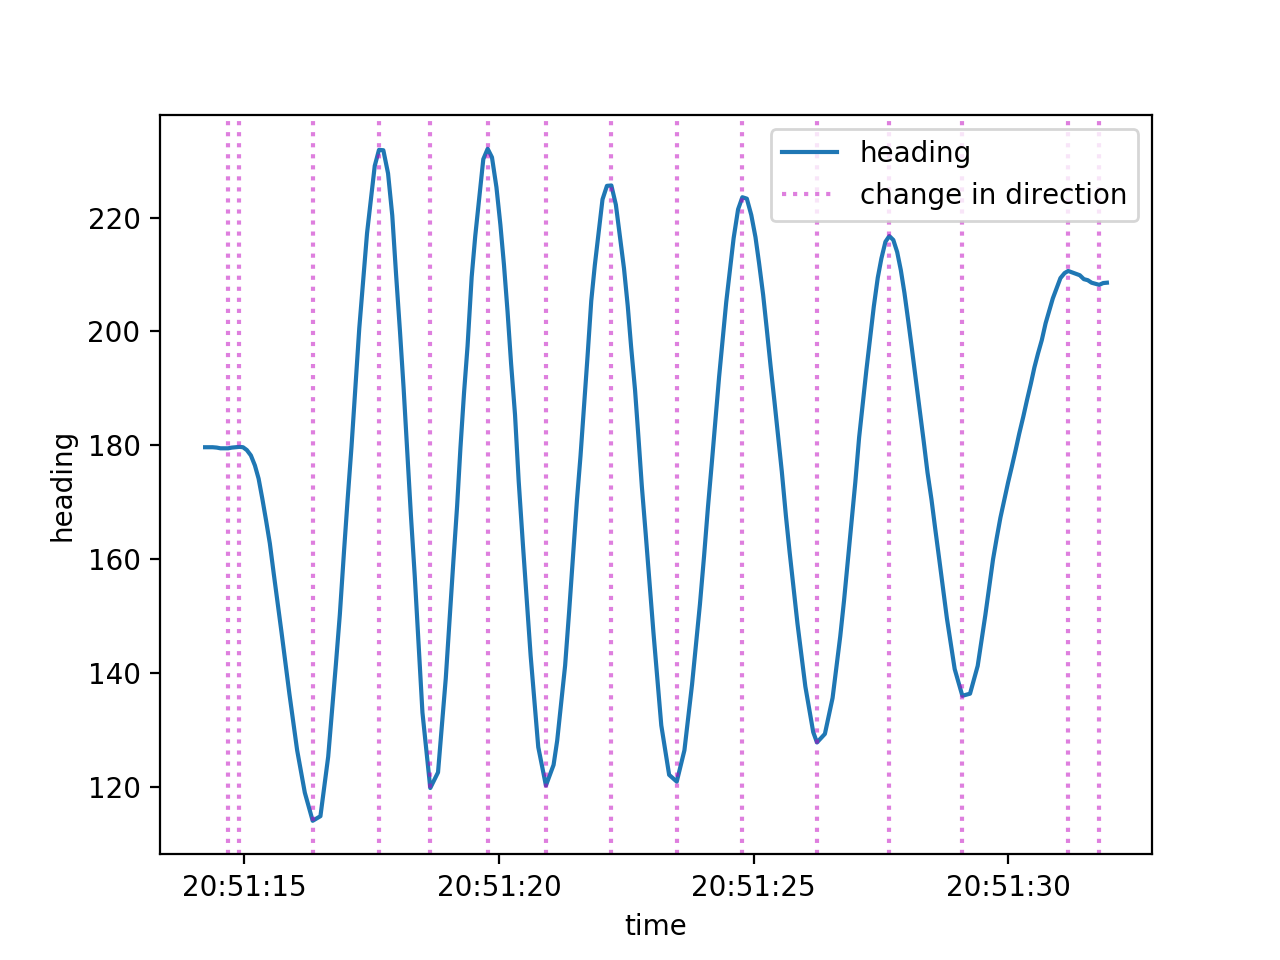

In [8]:
fig, ax = plt.subplots()
ax.plot(df.index, df["heading"], label="heading")

for xx in df[df["change"] == 1].index.to_list():
    plt.axvline(x=xx, color="m", ls="dotted", alpha=.5, label="change in direction")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_ylabel("heading")
ax.set_xlabel("time")
plt.show()

<IPython.core.display.Javascript object>


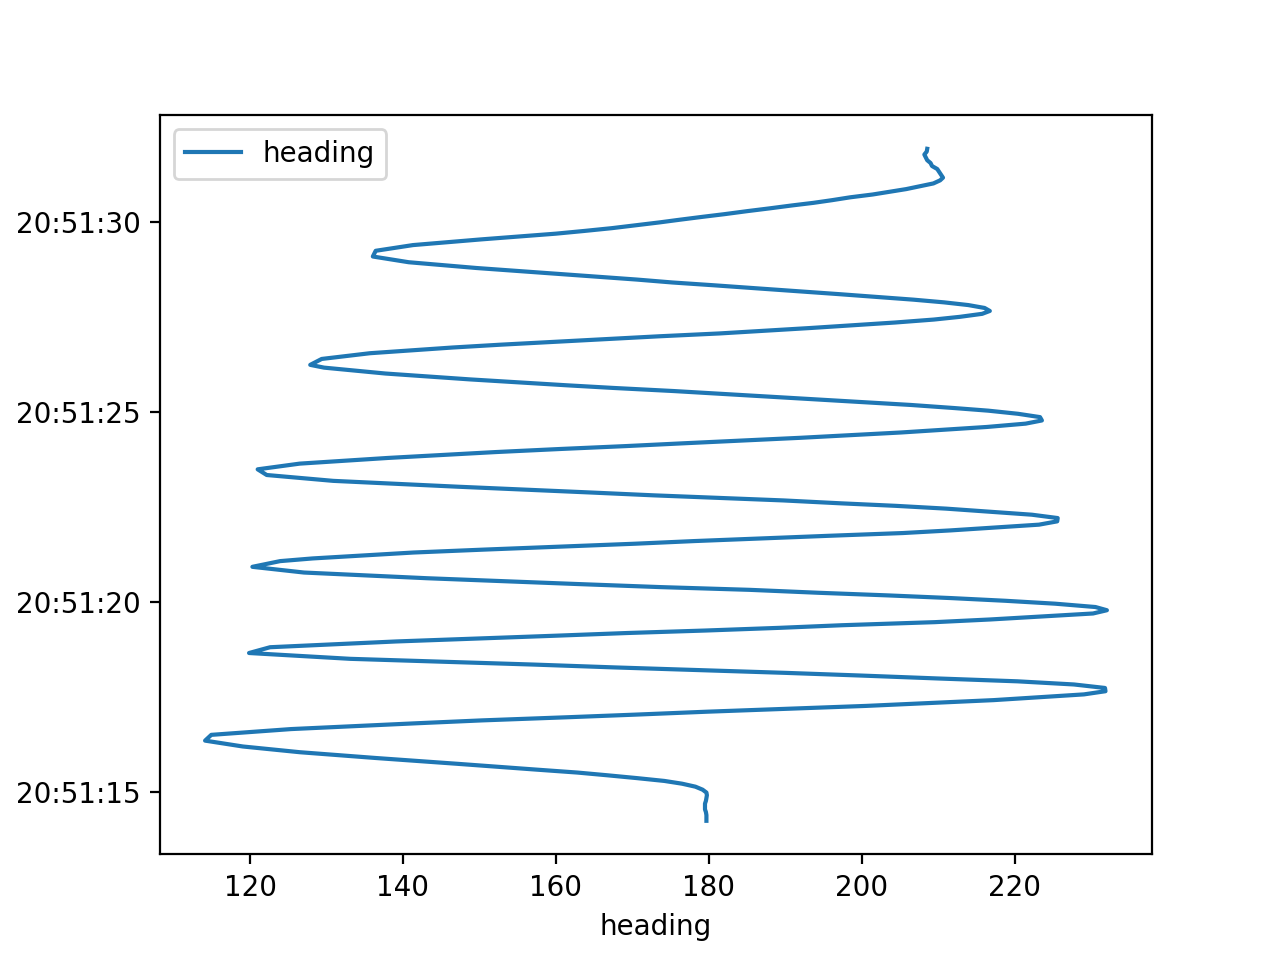

In [9]:
fig, ax = plt.subplots()
ax.plot(df["heading"], df.index, label="heading")
ax.legend()
ax.set_xlabel("heading")
ax.set_ylabel("time")
plt.show()